In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, norm
A=1
N=100
noise_types = ['Gaussian', 'Laplace', 'Cauchy']
Cg=1.78
mean=0
standard_deviation=1
gamma=np.sqrt(2*Cg)
tolerance=0.0001
n_iters = 10000

In [0]:
def generate_data(a=A, n=N, noise='Gaussian', noise_mean=mean, noise_stddev=standard_deviation):
  if noise not in noise_types:
    print("Error. Unexpected noise type.")
    print("Returning zero")
    return 0
  else:
    # A = a*np.ones(n)
    if noise == 'Gaussian':
      N = np.random.normal(loc=noise_mean, scale=noise_stddev, size=n)
      y = a + N
    elif noise == 'Laplace':
      N = np.random.laplace(loc=0, scale=noise_stddev/np.sqrt(2), size=n)
      y = a + N
    else:
      N = cauchy.rvs(loc=noise_mean, scale=gamma, size=n)
      # loc=mean is loose here as the centre of the cauchy distribution is not it's expected value, which does not happen to exist
      y = a + N
    return y

In [0]:
def newton_raphson_cauchy_RV(x=A*np.ones(N), gamma=gamma, tolerance=tolerance,n_iter=10000):
  theta = np.median(x)
  l_dash = 2*np.sum((x-theta)/(gamma**2+(x-theta)**2))
  iter_ = 0 
  while abs(l_dash) > tolerance :
    iter_ += 1
    if iter_ > n_iter:
      break
    l_double_dash = 2*np.sum(((x-theta)**2-gamma**2)/((gamma**2+(x-theta)**2)**2))
    theta = theta - l_dash/l_double_dash
    l_dash = 2*np.sum((x-theta)/(gamma**2+(x-theta)**2))
  return theta

In [0]:
def calculate_MLE(data_samples=A*np.ones(N), noise='Gaussian'):
  if noise not in noise_types:
    print("Error. Unexpected noise type.")
    print("Returning zero")
    return 0
  else:
    if noise == 'Gaussian':
      return np.mean(data_samples)
    elif noise == 'Laplace':
      return np.median(data_samples)
    else:
      return newton_raphson_cauchy_RV(x=data_samples)

In [0]:
def expectation_variance(a=A, n=N, noise='Gaussian', noise_mean=mean, noise_stddev=standard_deviation, n_iter=n_iters):
  '''
  Returns mean and variance of the ML estimate obtained over n_iter realisations
  '''
  if noise not in noise_types:
    print("Error. Unexpected noise type.")
    print("Returning zero")
    return 0
  else:
    a_hat_vals = np.zeros(n_iter)
    for i in range(n_iter):
      data_samples = generate_data(a=a, n=n, noise=noise, noise_mean=noise_mean, noise_stddev=noise_stddev)
      a_hat = calculate_MLE(data_samples=data_samples, noise=noise)
      a_hat_vals[i] = a_hat
    return np.mean(a_hat_vals), (np.mean(a_hat_vals**2)-np.mean(a_hat_vals)**2)

In [0]:
def generate_cdf_pdf(a=A, n=N, noise='Gaussian', noise_mean=mean, noise_stddev=standard_deviation, n_iter=n_iters,cdf=True):
  '''
  Function to generate the cdf and the pdf of the ML estimate based on n_iter realisations.
  cdf = False generates the pdf
  '''
  from scipy.stats import stats
  if noise not in noise_types:
    print("Error. Unexpected noise type.")
    print("Returning zero")
    return 0
  else:
    a_hat_vals = np.zeros(n_iter)
    for i in range(n_iter):
      data_samples = generate_data(a=a, n=n, noise=noise, noise_mean=noise_mean, noise_stddev=noise_stddev)
      a_hat = calculate_MLE(data_samples=data_samples, noise=noise)
      a_hat_vals[i] = a_hat
    a_hat_vals = np.sqrt(n)*np.sort(a_hat_vals-a)
    # p = 1.*np.arange(n_iter)/(n_iter-1)
    plt.hist(a_hat_vals,bins='auto',density=True,cumulative=cdf,histtype='step')
    if noise == 'Gaussian':
      mu = 0; sigma=1
    elif noise == 'Laplace':
      mu = 0; sigma=np.sqrt(0.5)
    else:
      mu = 0; sigma=np.sqrt(2*Cg)
    x = np.linspace(mu-5*sigma, mu+5*sigma, 1000)
    if cdf:
      cdf_ = np.cumsum(norm.pdf(x, mu, sigma))
      cdf_ = np.divide(cdf_,cdf_[-1])
      plt.plot(x, cdf_ , label='actual_cdf')
    else:
      plt.plot(x, norm.pdf(x, mu, sigma), label='actual_pdf')
    plt.legend()
    plt.grid(True)
    if cdf:
      plt.title(r'CDF of $\sqrt{n}$($Â-A_{0}$) for n=%i' %n)
    else:
      plt.title(r'PDF of $\sqrt{n}$(Â-$A_{0}$) for n=%i' %n)
    plt.xlabel('$x$')
    plt.ylabel('$p$')
    plt.show()

In [0]:
generate_cdf_pdf(noise="Cauchy", n=1000)

## **Expectation Value of Â vs $N$**


We can observe that in all the three cases, $E[Â]$ converges to the the actual value of $A=1$ or $A=10%=$, when sufficient number of samples, i.e. $N$ is chosen. In the case, where Cauchy noise is added to the actual value, for small values of $N$, the results fail to converge which can be explained by the fact the MLE is essentially calculated using Newton-Raphson method, which needs sufficient data samples to converge.


In [0]:
for a in [1,10]:
  for noise in noise_types:
    for n in np.logspace(0,4,5):
      mean,_ = expectation_variance(a=a,n=int(n),noise=noise)
      print('A = {}, N = {}, Noise Type = {}, E[Â] = {:.4f}'.format(a,int(n),noise,mean))

A = 1, N = 1, Noise Type = Gaussian, E[Â] = 0.9936
A = 1, N = 10, Noise Type = Gaussian, E[Â] = 0.9997
A = 1, N = 100, Noise Type = Gaussian, E[Â] = 0.9985
A = 1, N = 1000, Noise Type = Gaussian, E[Â] = 1.0001
A = 1, N = 10000, Noise Type = Gaussian, E[Â] = 1.0002
A = 1, N = 1, Noise Type = Laplace, E[Â] = 1.0052
A = 1, N = 10, Noise Type = Laplace, E[Â] = 1.0019
A = 1, N = 100, Noise Type = Laplace, E[Â] = 1.0005
A = 1, N = 1000, Noise Type = Laplace, E[Â] = 1.0000
A = 1, N = 10000, Noise Type = Laplace, E[Â] = 0.9999
A = 1, N = 1, Noise Type = Cauchy, E[Â] = 2.3194
A = 1, N = 10, Noise Type = Cauchy, E[Â] = 309.9613
A = 1, N = 100, Noise Type = Cauchy, E[Â] = 1.0025
A = 1, N = 1000, Noise Type = Cauchy, E[Â] = 1.0000
A = 1, N = 10000, Noise Type = Cauchy, E[Â] = 0.9997
A = 10, N = 1, Noise Type = Gaussian, E[Â] = 9.9967
A = 10, N = 10, Noise Type = Gaussian, E[Â] = 10.0042
A = 10, N = 100, Noise Type = Gaussian, E[Â] = 10.0003
A = 10, N = 1000, Noise Type = Gaussian, E[Â] = 10.0001
A

## **Variance of Â vs $N$**

As $N$ grows, the variance falls sharply except the aberration in the case of Cauchy noise addition. Such a trend is expected because as higher number of points are sampled, the uncertainity (variance) also decreases.

In [0]:
for a in [1,10]:
  for noise in noise_types:
    for n in np.logspace(0,4,5):
      _,var = expectation_variance(a=a,n=int(n),noise=noise)
      print('A = {}, N = {}, Noise Type = {}, var[Â] = {:.4f}'.format(a,int(n),noise,var))

A = 1, N = 1, Noise Type = Gaussian, var[Â] = 0.9801
A = 1, N = 10, Noise Type = Gaussian, var[Â] = 0.0996
A = 1, N = 100, Noise Type = Gaussian, var[Â] = 0.0101
A = 1, N = 1000, Noise Type = Gaussian, var[Â] = 0.0010
A = 1, N = 10000, Noise Type = Gaussian, var[Â] = 0.0001
A = 1, N = 1, Noise Type = Laplace, var[Â] = 1.0094
A = 1, N = 10, Noise Type = Laplace, var[Â] = 0.0718
A = 1, N = 100, Noise Type = Laplace, var[Â] = 0.0059
A = 1, N = 1000, Noise Type = Laplace, var[Â] = 0.0005
A = 1, N = 10000, Noise Type = Laplace, var[Â] = 0.0001
A = 1, N = 1, Noise Type = Cauchy, var[Â] = 372711.2147
A = 1, N = 10, Noise Type = Cauchy, var[Â] = 1222332522.6350
A = 1, N = 100, Noise Type = Cauchy, var[Â] = 0.0734
A = 1, N = 1000, Noise Type = Cauchy, var[Â] = 0.0071
A = 1, N = 10000, Noise Type = Cauchy, var[Â] = 0.0007
A = 10, N = 1, Noise Type = Gaussian, var[Â] = 1.0126
A = 10, N = 10, Noise Type = Gaussian, var[Â] = 0.0996
A = 10, N = 100, Noise Type = Gaussian, var[Â] = 0.0099
A = 10, N =

## **CDF of $\sqrt{N}(\hat{A}-A_0)$ vs $N$**

From theory, we know that $\sqrt{n}(\hat{A}-A_0)\rightarrow\mathcal{N}(0,I(\theta)^{-1})$ in distribution. We plot both the actual CDFs as well as the theoretical CDFs in the three cases and see that the results are as expected.

**************************************************Noise Type: Gaussian **************************************************


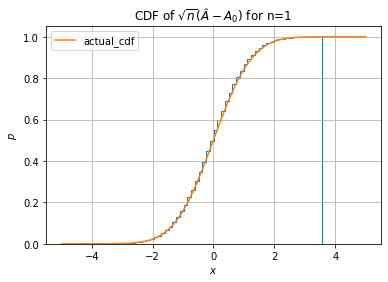

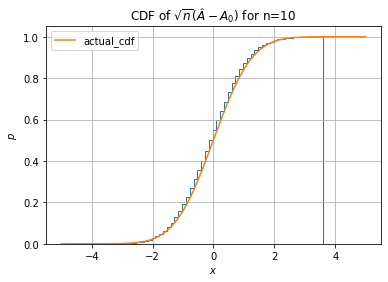

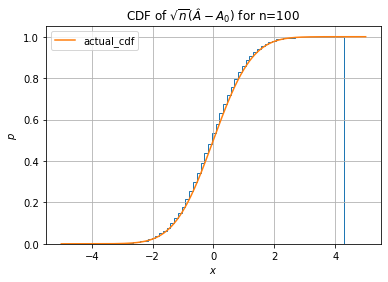

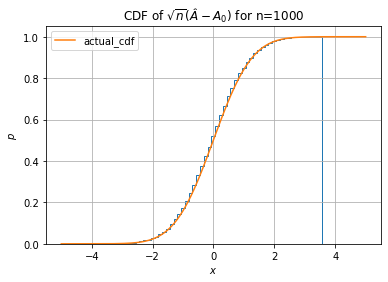

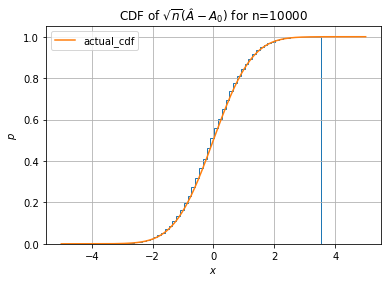

**************************************************Noise Type: Laplace **************************************************


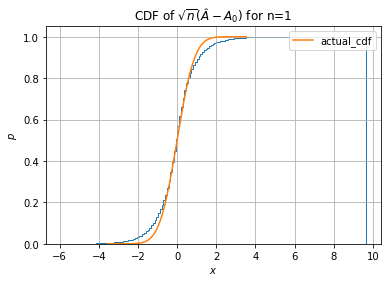

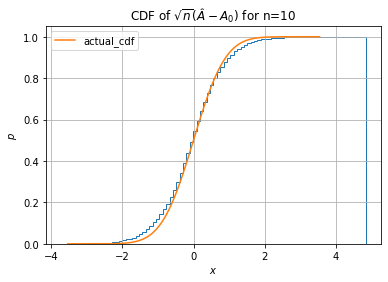

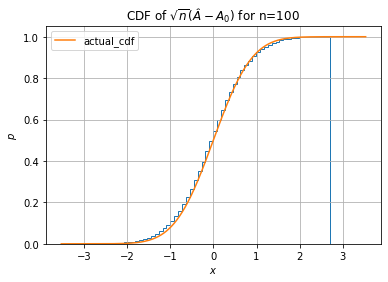

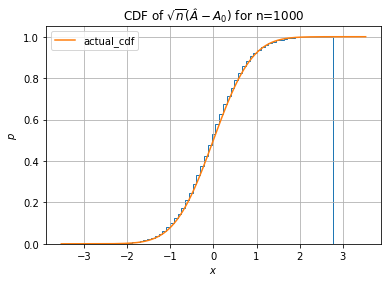

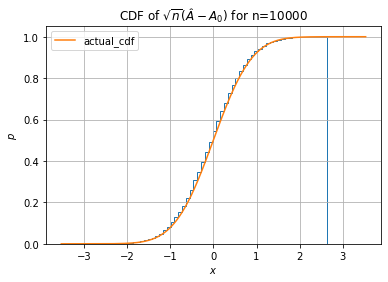

**************************************************Noise Type: Cauchy **************************************************


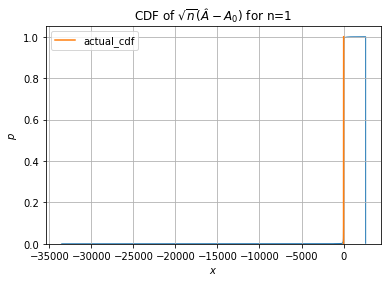

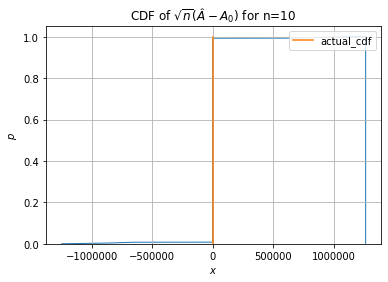

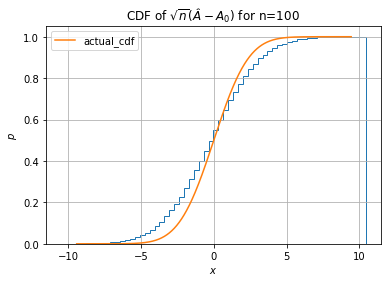

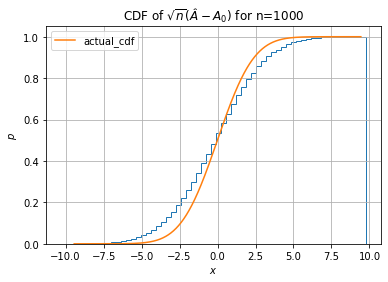

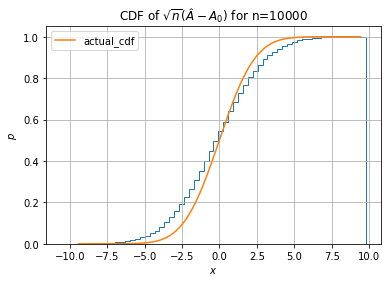

In [0]:
for noise in noise_types:
  print('*'*50+'Noise Type:', noise,'*'*50)
  for n_ in np.logspace(0,4,5):
    generate_cdf_pdf(a=1,n=int(n_),noise=noise,noise_mean=0,cdf=True)

## **PDF of $\sqrt{N}(\hat{A}-A_0)$ vs $N$**

From theory, we know that $\sqrt{n}(\hat{A}-A_0)\rightarrow\mathcal{N}(0,I(\theta)^{-1})$ in distribution but not necessarily in probability too. We plot both the actual PDFs as well as the theoretical PDFs (assuming that distributions were normal distributions) in the three cases. We can observe that although the CDF of $\sqrt{n}(\hat{A}-A_0)$ was pretty similar to that of $\mathcal{N}(0,I(\theta)^{-1})$, then PDF need not necessarily match, especially in the case of Cauchy noise.  

**************************************************Noise Type: Gaussian **************************************************


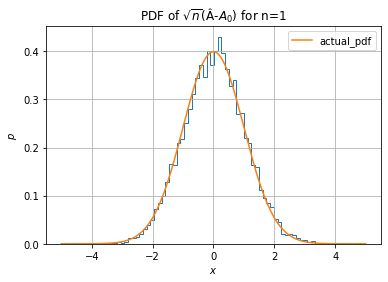

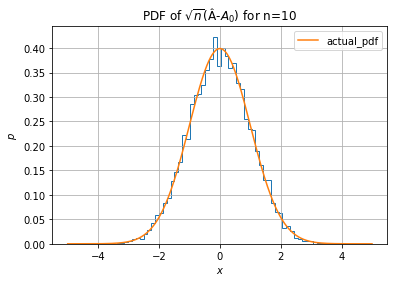

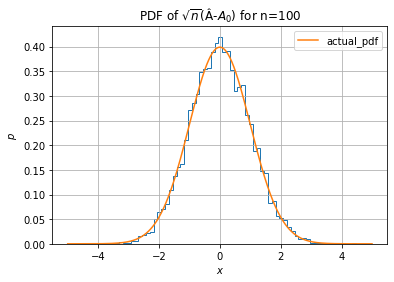

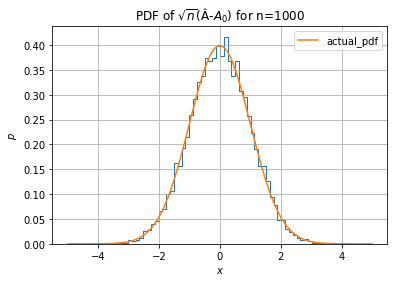

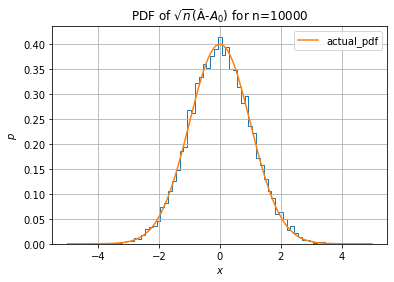

**************************************************Noise Type: Laplace **************************************************


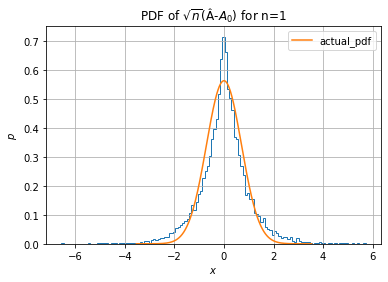

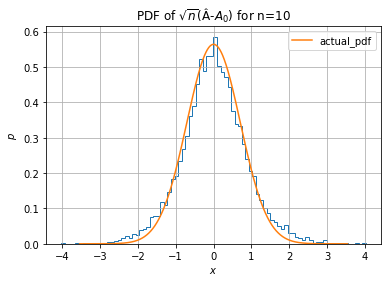

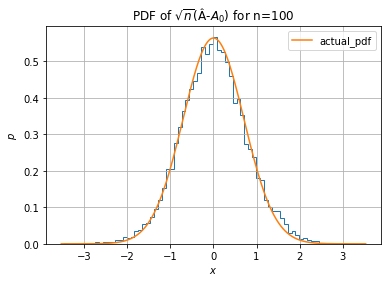

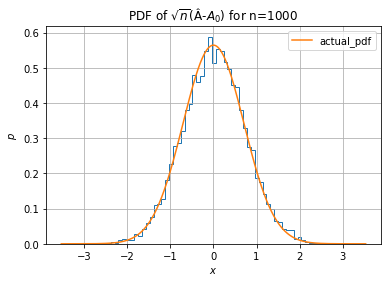

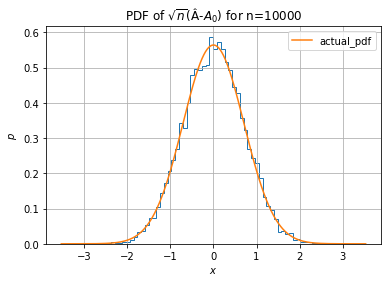

**************************************************Noise Type: Cauchy **************************************************


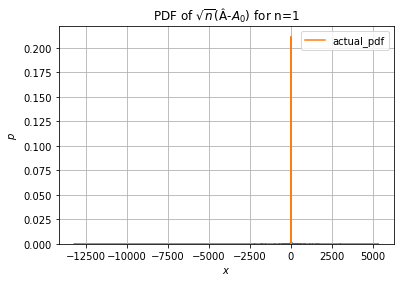

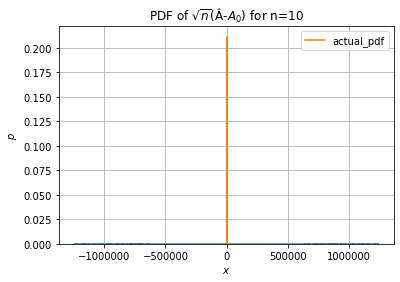

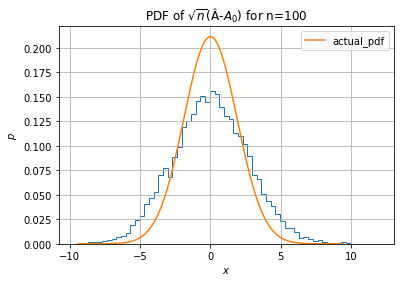

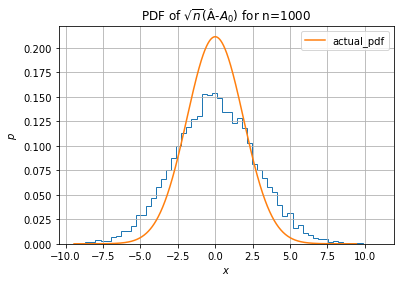

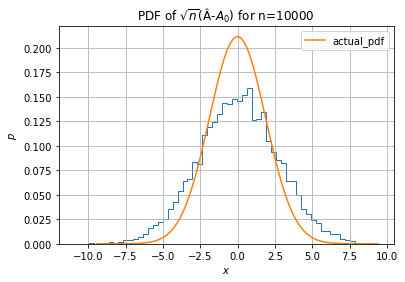

In [0]:
for noise in noise_types:
  print('*'*50+'Noise Type:', noise,'*'*50)
  for n_ in np.logspace(0,4,5):
    generate_cdf_pdf(a=1,n=int(n_),noise=noise,noise_mean=0,cdf=False)